In [814]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from pandas.api.types import CategoricalDtype

%matplotlib inline

In [815]:
path = 'C:\\Users\\linoyel\\Documents\\Linoy\\Data Scientist course\\part_2_tools\\Exercise 2 - Kaggle - Shelter Animal Outcomes'

In [816]:
df_animals = pd.read_csv(path+'\\train.csv', parse_dates=['DateTime'], index_col='AnimalID')
df_animals.head()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalID,,,,,,,,,
A671945,Hambone,2014-12-02 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
A683430,NaN,2014-11-07 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


# Data exploration

In [345]:
df_animals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26729 entries, A671945 to A706629
Data columns (total 9 columns):
Name              19038 non-null object
DateTime          26729 non-null datetime64[ns]
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: datetime64[ns](1), object(8)
memory usage: 2.0+ MB


We see that not all animals have names. Also there are some missing values in OutcomeSubtype - probably only certain OutcomeTypes have OutcomeSubtypes.

In [418]:
df_animals.describe()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,6374,22918,5,16,2,5,44,1380,366
top,Max,2015-11-08 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,136,19,10769,7816,15595,9779,3969,8810,2824
first,NaN,2013-01-10 09:31:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-02 18:59:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### How many cats and dogs do we have?

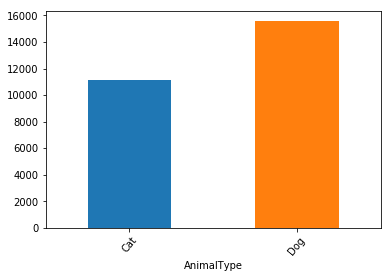

In [586]:
df_animals.groupby('AnimalType')['AnimalType'].count().plot(kind='bar', rot=50)

There are more dogs than cats in the shelter

In [566]:
grp_type.nunique()

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Cat,Dog
AnimalType,,,,,,,,,,,
Cat,3166,8652,5,13,1,5,44,60,146,1,1
Dog,4696,14519,5,14,1,5,43,1320,262,1,1


### How different outcomes are distributed?

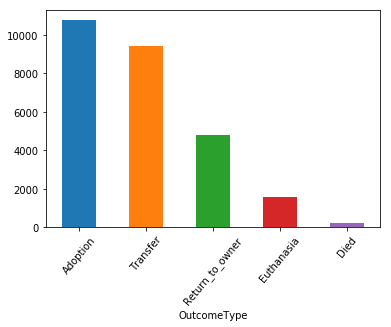

In [567]:
df_animals.groupby(['OutcomeType'])['AnimalType'].count().sort_values(ascending=False).plot(kind='bar', rot=50)

Most of the animals are being adopted or transfered. Let's see the outcome distribution by anymal type:

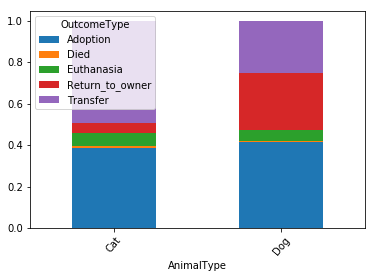

In [857]:
pd.crosstab(index=df_animals.AnimalType, columns=df_animals.OutcomeType, normalize='index').plot(kind='bar', stacked=True, rot=50)

We see that more dogs are returned to owner, while more cats are being transferred.

### Does breed influence on outcome? I assume that not mixed animals will be adopted more

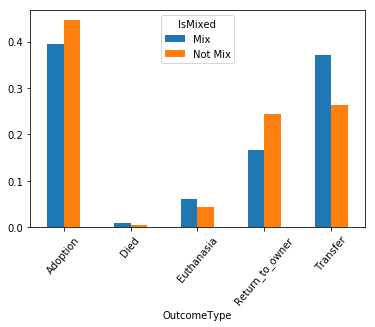

In [817]:
def is_mixed(Breed):
    Breed = str(Breed)
    if Breed.find('Mix') >= 0:
        return 'Mix'
    return 'Not Mix'

df_animals['IsMixed'] = df_animals.Breed.apply(is_mixed)

pd.crosstab(index=df_animals.OutcomeType, columns=df_animals.IsMixed, normalize='columns').plot(kind='bar', rot=50)

There is not a big difference between mixed and not mixed animals, so breed doesn't influence much on outcome, though the chances to be adopted or returned to owner are a bit higher for not mixed animals.

### How does age influence on outcome?

We have different age measurements, so first we'll calculate all ages in years and then assign them to age categories:

In [819]:
def get_age_years(AgeuponOutcome):
    AgeuponOutcome = str(AgeuponOutcome)
    if AgeuponOutcome == 'nan': return 0
    age = int(AgeuponOutcome.split(" ")[0])
    if AgeuponOutcome.find('year') > -1: return age
    if AgeuponOutcome.find('month') > -1: return age / 12
    if AgeuponOutcome.find('week') > -1: return age / 52
    if AgeuponOutcome.find('day') > -1: return age / 365
    else: return 0

df_animals['AgeInYears'] = df_animals.AgeuponOutcome.apply(get_age_years)

In [820]:
labels = ['baby', 'young', 'young adult', 'adult', 'old']
df_animals['AgeCategory'] = pd.cut(df_animals['AgeInYears'], bins=[0, 1, 5, 10, 15, 20], right=False, labels=labels)

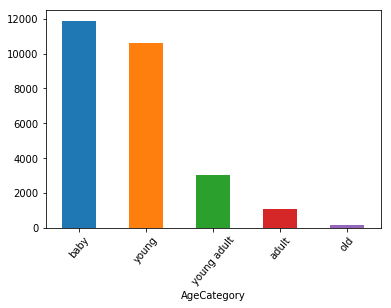

In [590]:
df_animals.groupby('AgeCategory')['AnimalType'].count().plot(kind='bar', rot=50)

We see that most of the animals in the shelter are babies or young.

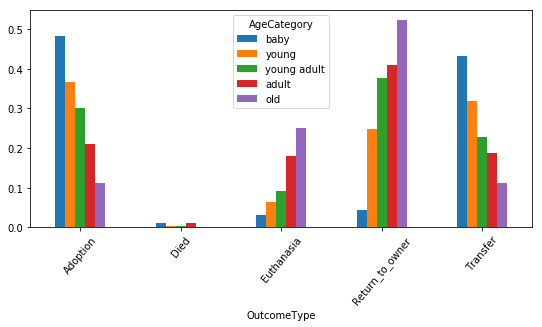

In [821]:
pd.crosstab(index=df_animals.OutcomeType, columns=df_animals.AgeCategory, normalize='columns').plot(kind='bar', rot=50, figsize=(9, 4))

As expected, we see that as an animal gets older it has less chances to be adopted or transferred. Older animals are returned to owners more often than younger ones - probably bacause owners that had an animal for a long time regret and take it back. Let's see if the influence of age differs between cats and dogs:

In [822]:
Dogs = df_animals['AnimalType']=='Dog'
Cats = ~Dogs

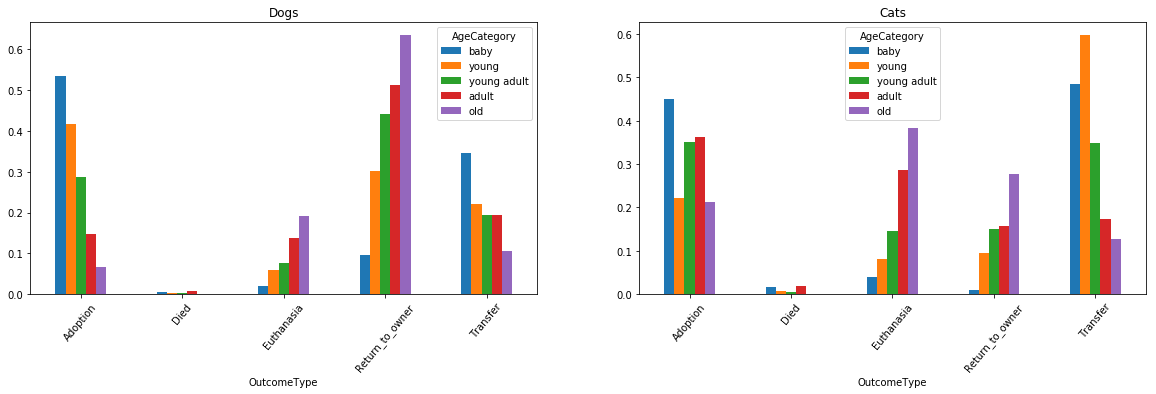

In [823]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
pd.crosstab(index=df_animals[Dogs].OutcomeType, columns=df_animals.AgeCategory, normalize='columns').plot(kind='bar', rot=50, ax=ax1, title='Dogs')
pd.crosstab(index=df_animals[Cats].OutcomeType, columns=df_animals.AgeCategory, normalize='columns').plot(kind='bar', rot=50, ax=ax2, title='Cats')

Nothing interesting here.

### Let's investigate the connection between outcome type and outcome subtype:

In [824]:
df_animals.groupby('OutcomeSubtype')['OutcomeType'].nunique().sort_values(ascending=False).head()

OutcomeSubtype
Barn           2
Suffering      1
SCRP           1
Rabies Risk    1
Partner        1
Name: OutcomeType, dtype: int64

In [825]:
df_animals.loc[df_animals.OutcomeSubtype == 'Barn']

,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,IsMixed,AgeInYears,AgeCategory
AnimalID,,,,,,,,,,,,
A695421,Percy,2015-01-26 14:55:00,Transfer,Barn,Cat,Neutered Male,3 years,Domestic Shorthair Mix,Black,Mix,3.0,young
A686921,NaN,2014-09-15 13:24:00,Adoption,Barn,Cat,Neutered Male,4 years,Domestic Shorthair Mix,Blue Tabby,Mix,4.0,young


We see that only if an outcome subtype is 'Barn' then there might be more than 1 outcome (either transfer or adoption).

### Let's see how sex influences on outcome:

In [826]:
def get_sex(SexuponOutcome):
    SexuponOutcome = str(SexuponOutcome)
    if SexuponOutcome == 'nan': return 'Unknown'
    if SexuponOutcome.find('Male') > -1: return 'Male'
    if SexuponOutcome.find('Female') > -1: return 'Female'
    else: return 'Unknown'

df_animals['Sex'] = df_animals.SexuponOutcome.apply(get_sex)


In [827]:
df_animals['IsIntact'] = pd.np.where(df_animals.SexuponOutcome.str.contains("Unknown"), "Unknown",
                         pd.np.where(df_animals.SexuponOutcome.str.contains("Intact"), "Intact", "Neutered/Spayed"))

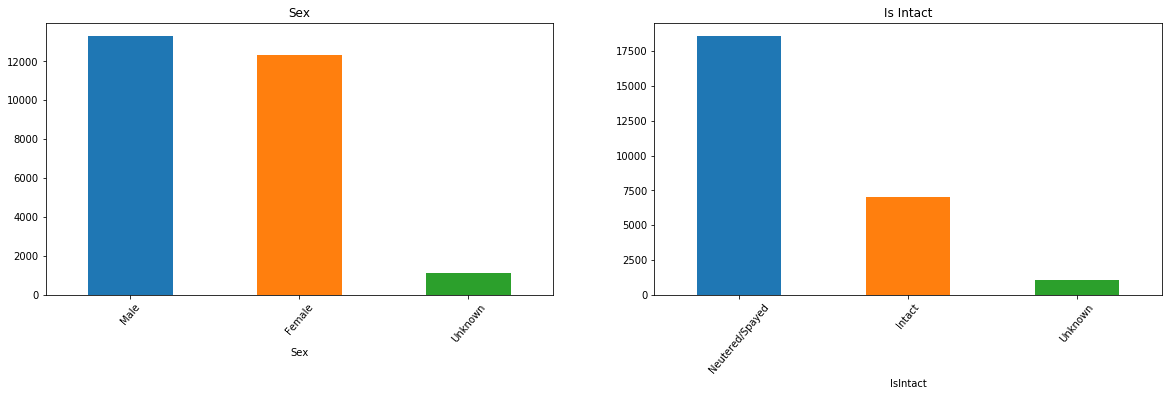

In [828]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
df_animals.groupby('Sex')['AnimalType'].count().sort_values(ascending=False).plot(kind='bar', rot=50, ax=ax1, title='Sex')
df_animals.groupby('IsIntact')['AnimalType'].count().sort_values(ascending=False).plot(kind='bar', rot=50, ax=ax2, title='Is Intact')

We have a bit more males than females and most of them are neutered/spayed. Now let's see if there is an influence on outcome:

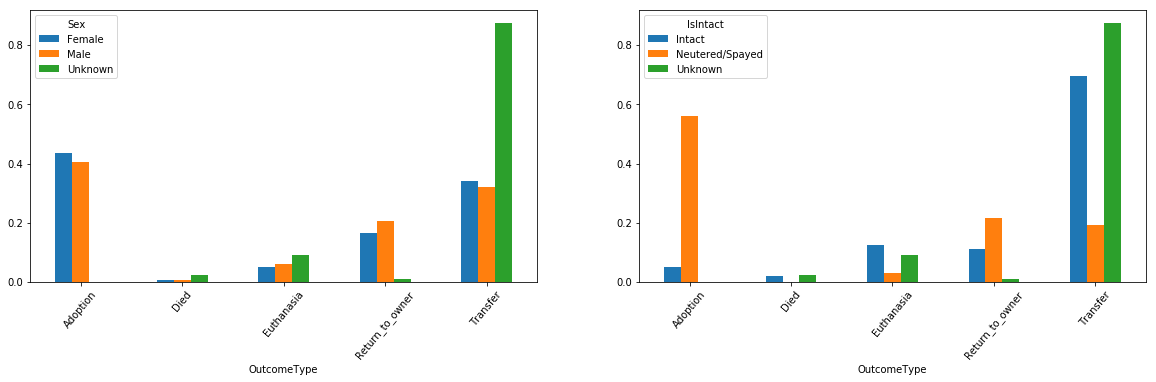

In [829]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
pd.crosstab(index=df_animals.OutcomeType, columns=df_animals.Sex, normalize='columns').plot(kind='bar', rot=50, ax=ax1)
pd.crosstab(index=df_animals.OutcomeType, columns=df_animals.IsIntact, normalize='columns').plot(kind='bar', rot=50, ax=ax2)

If sex is unknown there is more probability that the animal will be transferred. Neutered/spayed animals have much more probability to be adopted than intact ones.

### Some of the animals don't have names. I wonder if it matters.

In [830]:
df_animals['IsNamed'] = df_animals['Name'].notna()

In [831]:
df_animals.groupby(df_animals.IsNamed)['IsNamed'].count()

IsNamed
False     7691
True     19038
Name: IsNamed, dtype: int64

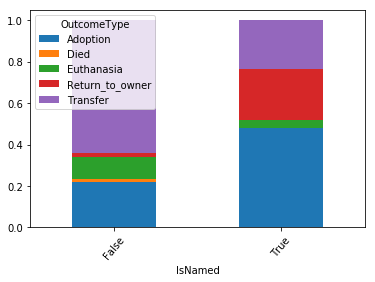

In [832]:
pd.crosstab(index=df_animals.IsNamed, columns=df_animals.OutcomeType, normalize='index').plot(kind='bar', stacked = True, rot=50)

Most of the animals without names are being transferred, while most of the animals with names are being adopted. Also, animals with names are more likely to be returned to owners than animals without names.

### Every animal has a color. I'll devide the Color column into less categories - only by the first part of the column, so it will be easier to see it's impact on outcome type.

In [833]:
df_animals['ColorCategory'] = df_animals['Color'].str.split('/').str[0].str.split().str[0]

In [834]:
df_animals.groupby(df_animals.ColorCategory)['ColorCategory'].count().sort_values(ascending=False).head()

ColorCategory
Black    6646
Brown    5318
White    3344
Blue     2149
Tan      1674
Name: ColorCategory, dtype: int64

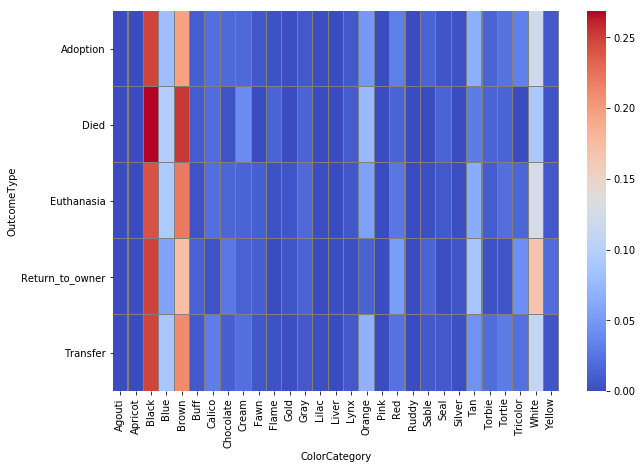

In [835]:
color_outcome = pd.crosstab(index=df_animals.OutcomeType, columns=df_animals.ColorCategory, normalize='index')
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(ax=ax, data=color_outcome, 
            linecolor='grey', cmap='coolwarm',
            linewidths=.1)

In [836]:
df_animals.loc[df_animals.ColorCategory == 'Black'].groupby('OutcomeType')['OutcomeType'].count()

OutcomeType
Adoption           2679
Died                 53
Euthanasia          377
Return_to_owner    1197
Transfer           2340
Name: OutcomeType, dtype: int64

Most of the animals are black or brown so it makes sense that there will be a high correlation between these colors and outcome type.

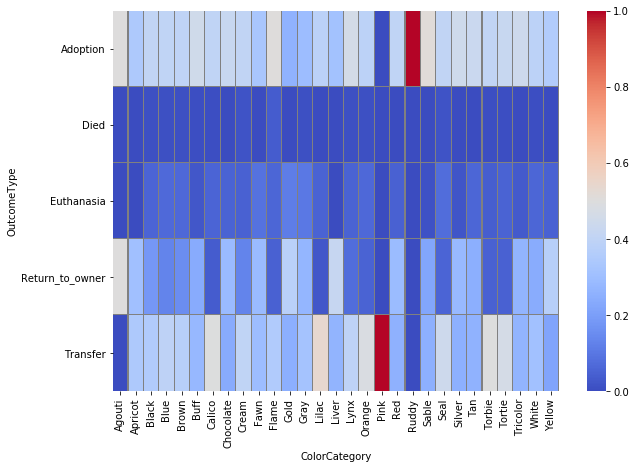

In [837]:
color_outcome = pd.crosstab(index=df_animals.OutcomeType, columns=df_animals.ColorCategory, normalize='columns')
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(ax=ax, data=color_outcome, 
            linecolor='grey', cmap='coolwarm',
            linewidths=.1)

In [838]:
df_animals.loc[df_animals.ColorCategory == 'Pink'].groupby('OutcomeType')['OutcomeType'].count()

OutcomeType
Transfer    1
Name: OutcomeType, dtype: int64

In [839]:
df_animals.loc[df_animals.ColorCategory == 'Ruddy'].groupby('OutcomeType')['OutcomeType'].count()

OutcomeType
Adoption    1
Name: OutcomeType, dtype: int64

The high correlation between Pink color and Transfer, and between Ruddy color and Adoption is explained because we have only 1 record of each type.
The final conclusion is that here is no influence of color on outcome type.

### Let's investigate if we can get any information from the date and time of leaving the shelter:

In [840]:
df_animals['Year'] = df_animals['DateTime'].dt.year

In [841]:
df_animals['Month'] = df_animals['DateTime'].dt.month

In [842]:
df_animals['YearMonth'] = df_animals['DateTime'].map(lambda x: 100*x.year + x.month)

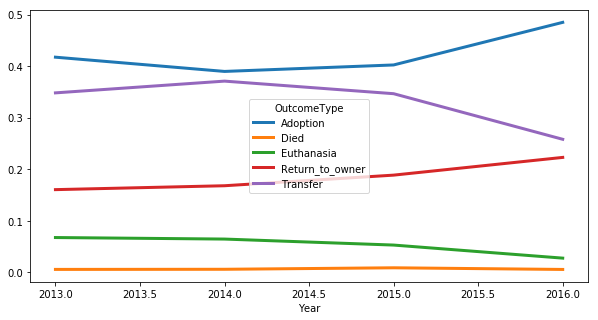

In [852]:
pd.crosstab(index=df_animals.Year, columns=df_animals.OutcomeType, normalize='index').plot(figsize=(10,5), linewidth=3)

We can see that as years pass by adoption and return to owner tendency grow, while transfer and euthanasia tendency are decreasing.

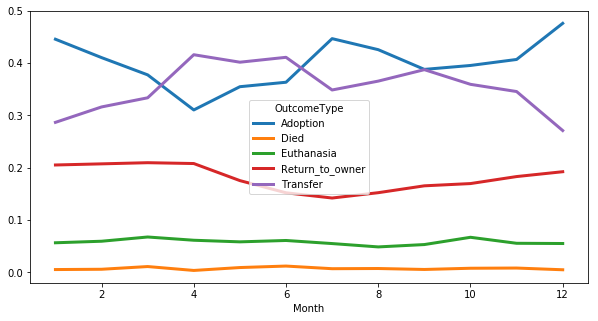

In [855]:
pd.crosstab(index=df_animals.Month, columns=df_animals.OutcomeType, normalize='index').plot(figsize=(10,5), linewidth=3)

Animals are more likely to be adopted on New Years and during summer holidays.